<a href="https://colab.research.google.com/github/Mingnarto/TensorFlow/blob/main/transfer_learning_in_tensorflow_part_1_feature_extraction_video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow Part 1: Feature Extraction

Transfer learning is leveraging a working model's existing architecture and learned patterns for our own problem.

There are two main benefits:
1. Can leverage an existing neural network architecture proven to work on problems similar to our own.
2. Can leverage a working neural network architecture which has already learned patterns on similar data to our own, then we can adapt those patterns to our own data.

In [ ]:
# Are we using a GPU?
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



## Downloading and becoming one with the data

In [ ]:
# Get data (10% of 10 food classes from Food101)
import zipfile

# Download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip downloaded file
zip_ref = zipfile.ZipFile('10_food_classes_10_percent.zip')
zip_ref.extractall()
zip_ref.close()

--2021-06-30 08:19:00--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.62.128, 172.217.164.144, 172.253.115.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.62.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   220MB/s    in 0.7s    

2021-06-30 08:19:01 (220 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
# How many images in each folder?
import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk('10_food_classes_10_percent'):
  print(f'There are {len(dirnames)} directories and {len(filenames)} images in "{dirpath}".')

There are 2 directories and 0 images in "10_food_classes_10_percent".
There are 10 directories and 0 images in "10_food_classes_10_percent/test".
There are 0 directories and 250 images in "10_food_classes_10_percent/test/chicken_curry".
There are 0 directories and 250 images in "10_food_classes_10_percent/test/hamburger".
There are 0 directories and 250 images in "10_food_classes_10_percent/test/sushi".
There are 0 directories and 250 images in "10_food_classes_10_percent/test/steak".
There are 0 directories and 250 images in "10_food_classes_10_percent/test/ice_cream".
There are 0 directories and 250 images in "10_food_classes_10_percent/test/ramen".
There are 0 directories and 250 images in "10_food_classes_10_percent/test/fried_rice".
There are 0 directories and 250 images in "10_food_classes_10_percent/test/grilled_salmon".
There are 0 directories and 250 images in "10_food_classes_10_percent/test/chicken_wings".
There are 0 directories and 250 images in "10_food_classes_10_percent

## Creating data loaders (preparing the data)

We'll use the `ImageDataGenerator` class to load in our images in batches.

In [ ]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224,224)
BATCH_SIZE = 32

train_dir = '10_food_classes_10_percent/train/'
test_dir = '10_food_classes_10_percent/test/'

train_datagen = ImageDataGenerator(rescale=1/225.)
test_datagen = ImageDataGenerator(rescale=1/225.)

print('Training images:')
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode='categorical')

print('Testing images:')
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMAGE_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode='categorical')

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


## Setting up callbacks (things to run whilst our model trains)

Callbacks are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks:

- Tracking experiments with TensorBoard callback
- Model checkpoint with the ModelCheckpoint callback
- Stopping a model from training (before it trains too long and overfits) with the EarlyStopping callback

In [ ]:
# Create TensorBoard callback (functionized because we need to create a new one for each model)
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + '/' + experiment_name + '/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f'Saving TensorBoard log files to: {log_dir}')
  return tensorboard_callback

## Creating models using TensorFlow Hub

In the past we've used TensorFlow to create our own models layer by layer from scratch.

Now we're going to do a similar process, except the majority of our model's are going to come from TensorFlow Hub.

We can access pretrained models on: https://tfhub.dev/

Browsing the TensorFlow Hub page and sorting for image classification, we found the following feature vector model link: https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1

In [ ]:
# Let's compare the following two models
resnet_url = 'https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5'

efficientnet_url = 'https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1'

In [ ]:
# Import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [ ]:
# Let's make a create_model() function to create a model from a URL
def create_model(model_url, num_classes=10):
  '''
  Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.
  
  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in the output layer,
    should be equal to number of target classes, deafault 10.

  Returns:
    An uncompiled Keras Sequential model_url as feature extractor
    layer and Dense output layer with num_classes output neurons.
  '''
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False,  # Freze the already learned patterns
                                           name='feature_extractor_layer',
                                           input_shape=IMAGE_SHAPE+(3,))

  # Create our own model
  model = tf.keras.Sequential([
                               feature_extractor_layer,
                               layers.Dense(num_classes, activation='softmax', name='output_layer')
  ])

  return model

## Creating and testing ResNet TensorFlow Hub Feature Extraction model

In [ ]:
# Create Resnet model
resnet_model = create_model(resnet_url,
                            num_classes=train_data_10_percent.num_classes)

In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extractor_layer (Ker (None, 2048)              23564800  
_________________________________________________________________
output_layer (Dense)         (None, 10)                20490     
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
# Compile our resnet model
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [ ]:
# Let's fit our ResNet model to the data (10 percent of 10 classes)
history_resnet = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  callbacks=[create_tensorboard_callback(dir_name='tensorflow_hub',
                                                                         experiment_name='resnet50v2')])

Saving TensorBoard log files to: tensorflow_hub/resnet50v2/20210630-055742
Epoch 1/5
24/24 [==============================] - 51s 761ms/step - loss: 2.0436 - accuracy: 0.3093 - val_loss: 1.3010 - val_accuracy: 0.5872
Epoch 2/5
24/24 [==============================] - 15s 648ms/step - loss: 0.9100 - accuracy: 0.7373 - val_loss: 0.8854 - val_accuracy: 0.7240
Epoch 3/5
24/24 [==============================] - 15s 652ms/step - loss: 0.6118 - accuracy: 0.8387 - val_loss: 0.7724 - val_accuracy: 0.7548
Epoch 4/5
24/24 [==============================] - 15s 650ms/step - loss: 0.4795 - accuracy: 0.8813 - val_loss: 0.7368 - val_accuracy: 0.7612
Epoch 5/5
24/24 [==============================] - 15s 652ms/step - loss: 0.3832 - accuracy: 0.9120 - val_loss: 0.6965 - val_accuracy: 0.7736


In [ ]:
# Evaluate the model
resnet_model.evaluate(test_data)

79/79 [==============================] - 12s 150ms/step - loss: 0.6965 - accuracy: 0.7736


[0.6965346932411194, 0.7735999822616577]

Wow!

That. Is. Incredible. Our transfer learning feature extractor model out performed ALL of the previous models we built by hand... (substantially) and in a quicker training time AND with only 10% of the training examples.

In [ ]:
# Let's create a function to plot our loss curves...
# Tidbit: You could put a function like this into a script called 'helper.py' and import it when you need it...

import matplotlib.pyplot as plt

# Plot the validation and training curves
def plot_loss_curves(history):
  '''
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow History object.

  Returns:
    Plots of training/validation loss and accuracy metrics.

  **WARNING: If you use metrics other than 'accuracy' this function might fail**
  '''
  training_loss = history.history['loss']
  val_loss = history.history['val_loss']

  training_accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))  # how many epochs did we run for?

  # Plot loss
  plt.plot(epochs, training_loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('loss')
  plt.xlabel('epochs')
  plt.legend()

  # plot accuracy
  plt.figure()
  plt.plot(epochs, training_accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('accuracy')
  plt.xlabel('epochs')
  plt.legend();

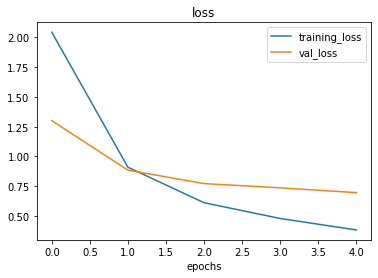

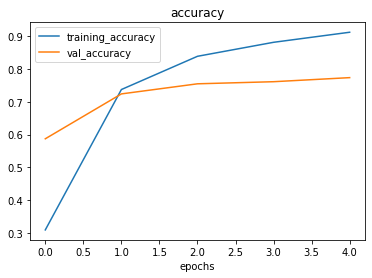

In [ ]:
plot_loss_curves(history_resnet)

## Creating and testing EfficientNetB0 TensorFlow Hub Feature Extraction model

In [ ]:
# Create EfficientNetB0 feature extractor model - details on EfficientNet: https://ai.googleblog.com/2019/05/efficientnet-improving-accuracy-and.html
efficientnet_model = create_model(model_url=efficientnet_url,
                                  num_classes=train_data_10_percent.num_classes)

# Compile EfficientNet model
efficientnet_model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

# Fit EfficientNet model to 10% of training data
efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                              epochs=5,
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks = [create_tensorboard_callback(dir_name='tensorflow_hub',
                                                                                       experiment_name='efficientnetB0')])

Saving TensorBoard log files to: tensorflow_hub/efficientnetB0/20210630-060740
Epoch 1/5
24/24 [==============================] - 24s 744ms/step - loss: 1.8459 - accuracy: 0.4467 - val_loss: 1.3140 - val_accuracy: 0.7052
Epoch 2/5
24/24 [==============================] - 15s 624ms/step - loss: 1.0862 - accuracy: 0.7520 - val_loss: 0.8986 - val_accuracy: 0.8012
Epoch 3/5
24/24 [==============================] - 14s 619ms/step - loss: 0.7810 - accuracy: 0.8200 - val_loss: 0.7277 - val_accuracy: 0.8332
Epoch 4/5
24/24 [==============================] - 15s 623ms/step - loss: 0.6271 - accuracy: 0.8653 - val_loss: 0.6424 - val_accuracy: 0.8460
Epoch 5/5
24/24 [==============================] - 14s 618ms/step - loss: 0.5298 - accuracy: 0.8893 - val_loss: 0.5865 - val_accuracy: 0.8564


In [ ]:
# Evaluate the model
efficientnet_model.evaluate(test_data)

79/79 [==============================] - 11s 143ms/step - loss: 0.5865 - accuracy: 0.8564


[0.5865087509155273, 0.8564000129699707]

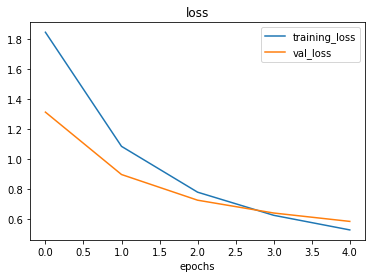

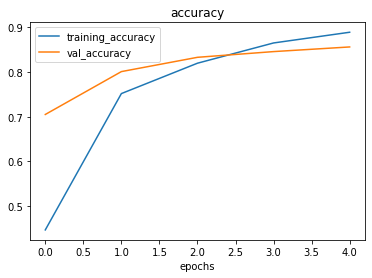

In [ ]:
# Plot loss curves
plot_loss_curves(efficientnet_history)

In [ ]:
efficientnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extractor_layer (Ker (None, 1280)              4049564   
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extractor_layer (Ker (None, 2048)              23564800  
_________________________________________________________________
output_layer (Dense)         (None, 10)                20490     
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
# How many layers does our efficientnet feature extractor have?
len(efficientnet_model.layers[0].weights)

309

## Different types of transfer learning

- **'As is' transfer learning** - using an existing model with no changes what so ever (e.g. using ImageNet on 1000 ImageNet classes, non of your own)
- **'Feature extraction' transfer learnin**g - use the prelearned patterns of an existing model (e.g. EfficientNetB0 on ImageNet) and adjust the putput layer for your own problem (e.g. 1000 classes -> 10 classes of food)
- **'Fine-tuning' transfer learning** - use the prelearned patterns of an existing model and 'fine-tune' many or all of the underlying layers (including new output layers)

## Comparing our models results using TensorBoard

> **NOTE:** When you upload things to TensorBoard.dev, your experiments are public. So if you're running private experiments (things you don't want others to see) do not upload them to TensorBoard.dev.

In [ ]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
--name 'EfficientNetB0 vs. ResNet50v2' \
--description 'Comparing two different TF Hub feature extraction model architecture using 10% of the training data' \
--one_shot

Our TensorBoard experiments are uploaded publically here: https://tensorboard.dev/experiment/4cjLWokSQsqQxsAxeNg5Bw/

In [ ]:
# Check out what TensorBoard experiments you have
!tensorboard dev list

2021-06-30 08:00:06.157035: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
Data for the "text" plugin is now uploaded to TensorBoard.dev! Note that uploaded data is public. If you do not want to upload data for this plugin, use the "--plugins" command line argument.
https://tensorboard.dev/experiment/4cjLWokSQsqQxsAxeNg5Bw/
	Name                 EfficientNetB0 vs. ResNet50v2
	Description          Comparing two different TF Hub feature extraction model architecture using 10% of the training data
	Id                   4cjLWokSQsqQxsAxeNg5Bw
	Created              2021-06-30 07:22:00 (38 minutes ago)
	Updated              2021-06-30 07:22:03 (38 minutes ago)
	Runs                 6
	Tags                 5
	Scalars              120
	Tensor bytes         0
	Binary object bytes  10144184
Total: 1 experiment(s)


In [ ]:
# Delete an experiment
#!tensorboard dev delete --experiment_id 4cjLWokSQsqQxsAxeNg5Bw

2021-06-30 07:21:41.026924: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
Data for the "text" plugin is now uploaded to TensorBoard.dev! Note that uploaded data is public. If you do not want to upload data for this plugin, use the "--plugins" command line argument.
Deleted experiment w9iD6lsBR5mCrE1NG5wDog.


In [ ]:
# Confirm the deletion by re-checking what experiments you have left
!tensorboard dev list

2021-06-30 07:21:48.901001: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
Data for the "text" plugin is now uploaded to TensorBoard.dev! Note that uploaded data is public. If you do not want to upload data for this plugin, use the "--plugins" command line argument.
No experiments. Use `tensorboard dev upload` to get started.


#######################################################################################################

In [ ]:
# mobilenet url
mobilenet_url = 'https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4'

In [ ]:
# Let's make a create_model() function to create a model from URL
def create_model(model_url, num_classes=10):
  '''
  Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.
  
  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in the output layer,
    should be equal to number of target classes, deafault 10.

  Returns:
    An uncompiled Keras Sequential model_url as feature extractor
    layer and Dense output layer with num_classes output neurons.
  '''
  # Download the pretrained model and and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False,  # Freze the already learned patterns
                                           name='feature_extractor_layer',
                                           input_shape=IMAGE_SHAPE + (3,))
  # Create our own model
  model = tf.keras.Sequential([
                               feature_extractor_layer,
                               layers.Dense(num_classes, activation='softmax', name='aoutput_layer')
  ])

  return model

In [ ]:
# Create mobilenet model
mobilenet_model = create_model(mobilenet_url,
                               num_classes=train_data_10_percent.num_classes)

In [ ]:
# Compile the model
mobilenet_model.compile(loss='categorical_crossentropy',
                        optimizer=tf.keras.optimizers.Adam(),
                        metrics=['accuracy'])

# Fit the model
mobilenet_history = mobilenet_model.fit(train_data_10_percent,
                                        epochs=5,
                                        steps_per_epoch=len(train_data_10_percent),
                                        validation_data=test_data,
                                        validation_steps=len(test_data),
                                        callbacks = [create_tensorboard_callback(dir_name='tensorflow_hub',
                                                                                 experiment_name='mobilenet')])

Saving TensorBoard log files to: tensorflow_hub/mobilenet/20210630-083145
Epoch 1/5
24/24 [==============================] - 91s 4s/step - loss: 0.4262 - accuracy: 0.9040 - val_loss: 0.6068 - val_accuracy: 0.8032
Epoch 2/5
24/24 [==============================] - 103s 4s/step - loss: 0.3145 - accuracy: 0.9347 - val_loss: 0.5654 - val_accuracy: 0.8168
Epoch 3/5
24/24 [==============================] - 89s 4s/step - loss: 0.2621 - accuracy: 0.9587 - val_loss: 0.5601 - val_accuracy: 0.8168
Epoch 4/5
24/24 [==============================] - 102s 4s/step - loss: 0.2177 - accuracy: 0.9667 - val_loss: 0.5538 - val_accuracy: 0.8196
Epoch 5/5
24/24 [==============================] - 88s 4s/step - loss: 0.1778 - accuracy: 0.9787 - val_loss: 0.5497 - val_accuracy: 0.8176


In [ ]:
# Let's create a function to plot our loss curves...
# Tidbit: You could put a function like this into a script called 'helper.py' and import it when you need it...

import matplotlib.pyplot as plt

# Plot the validation and training curves
def plot_loss_curves(history):
  '''
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow History object.

  Returns:
    Plots of training/validation loss and accuracy metrics.

  **WARNING: If you use metrics other than 'accuracy' this function might fail**
  '''
  training_loss = history.history['loss']
  val_loss = history.history['val_loss']

  training_accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))  # how many epochs did we run for?

  # Plot loss
  plt.plot(epochs, training_loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('loss')
  plt.xlabel('epochs')
  plt.legend()

  # plot accuracy
  plt.figure()
  plt.plot(epochs, training_accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('accuracy')
  plt.xlabel('epochs')
  plt.legend();

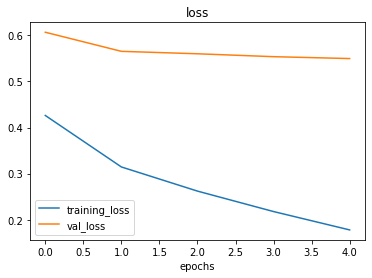

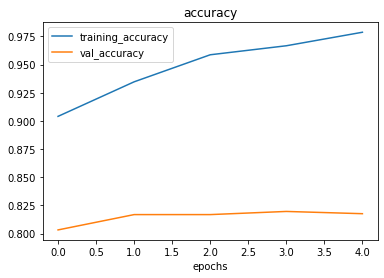

In [ ]:
# Plot loss curves
plot_loss_curves(mobilenet_history)

In [ ]:
# Evaluate the model
mobilenet_model.evaluate(test_data)

79/79 [==============================] - 83s 1s/step - loss: 0.5497 - accuracy: 0.8176


[0.5496887564659119, 0.8176000118255615]

#######################################################################################################